# Detection Demo
This workbook contains a short demo with a basic proof of concept for the gait event detection algorithm. It uses a small sample of the IMU data provided, and runs the detection algorithm on it. The results are then visualized using matplotlib.

The data used throughout this work comes from [Grouvel et al., 2023](https://www-nature-com.eux.idm.oclc.org/articles/s41597-023-02077-3). 

## 1. Data exploration

Import the data for for a chosen participant, session and trial:

In [1]:
import polars as pl

# Participants available: P01-P10
participant = "P01"
# Sessions available: S01
session = "S01"
# Trials available: SlowGait, Gait, FastGait, Running
trial = "Gait"
# Trial IDs available: varies per trial. Here I use "01" as an example.
trial_id = "01"

# Load the data
sample_df = pl.read_csv(f"../data/synchronised/{participant}_{session}_{trial}_{trial_id}.csv")

We'll focus on the gyroscope data from the feet IMUs in the medial-lateral direction (which corresponds to the y-axis of the IMU), as this is the focus of the event detection algorithm. 

In [2]:
left_foot = sample_df["P6_LF_gyro_y"]
right_foot = sample_df["P6_RF_gyro_y"]

Plot the signals:

(100.0, 200.0)

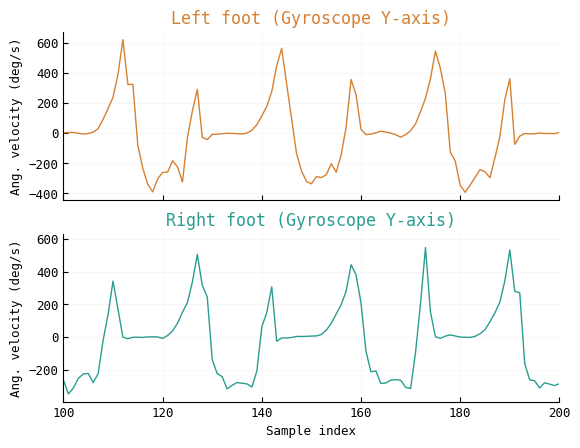

In [3]:
import matplotlib.pyplot as plt
plt.style.use("movetru.mplstyle")
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(left_foot, label="Left Foot Gyro Y", color=colours[0])
ax[0].set_title("Left foot (Gyroscope Y-axis)")
ax[0].set_ylabel("Ang. velocity (deg/s)")
ax[0].set_xlim([100, 200])

ax[1].plot(right_foot, label="Right Foot Gyro Y", color=colours[1])
ax[1].set_title("Right foot (Gyroscope Y-axis)", color=colours[1])
ax[1].set_xlabel("Sample index")
ax[1].set_ylabel("Ang. velocity (deg/s)")
ax[1].set_xlim([100, 200])

## 2. Data cleaning

Apply a Butterworth low-pass filter using a cutoff frequency determined from the FFT analysis.

First, visualise the frequency content of the signals using a Fast Fourier Transform (FFT), to determine a suitable cutoff frequency for the low-pass filter.

The chosen filtering frequency may seem aggressive, however this is to allow for reliable detection of local peaks, without higher order harmonics interfering.

Top 3 dominant frequencies:
  Left:  [np.float64(3.2098765432098766), np.float64(5.679012345679013), np.float64(6.17283950617284)]
  Right: [np.float64(3.2098765432098766), np.float64(5.679012345679013), np.float64(6.17283950617284)]

✓ Cutoff frequency: 7.2 Hz


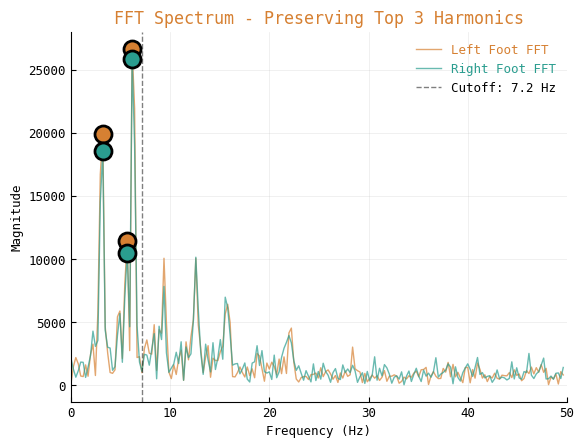

In [4]:
import numpy as np
from scipy.signal import find_peaks as scipy_find_peaks

# Calculate FFT for left foot and right foot signals
fft_left_foot = np.fft.fft(left_foot)
fft_right_foot = np.fft.fft(right_foot)

# Calculate the corresponding frequencies
fs = 100
freqs = np.fft.fftfreq(len(left_foot), d=1/fs)

# Work with positive frequencies only
positive_freqs = freqs[:len(freqs)//2]
left_magnitude = np.abs(fft_left_foot)[:len(freqs)//2]
right_magnitude = np.abs(fft_right_foot)[:len(freqs)//2]

# Find peaks in the FFT spectrum (dominant frequencies + harmonics)
min_peak_height = 0.1  # Peaks must be at least 20% of max amplitude
min_peak_distance = 2   # Minimum distance between peaks (in frequency bins)

left_peaks, _ = scipy_find_peaks(
    left_magnitude, 
    height=np.max(left_magnitude) * min_peak_height,
    distance=min_peak_distance
)
right_peaks, _ = scipy_find_peaks(
    right_magnitude, 
    height=np.max(right_magnitude) * min_peak_height,
    distance=min_peak_distance
)

# Get the frequencies and magnitudes of the peaks
left_peak_freqs = positive_freqs[left_peaks]
left_peak_mags = left_magnitude[left_peaks]
right_peak_freqs = positive_freqs[right_peaks]
right_peak_mags = right_magnitude[right_peaks]

# Sort by magnitude (strongest first)
left_sorted_idx = np.argsort(left_peak_mags)[::-1]
right_sorted_idx = np.argsort(right_peak_mags)[::-1]

# Select cutoff based on top N harmonics
n_harmonics_to_keep = 3  # Adjust this: 1 (most aggressive), 2-3 (balanced), 4+ (less aggressive)

# Get the top N frequencies from both feet
top_n_left = left_peak_freqs[left_sorted_idx[:n_harmonics_to_keep]]
top_n_right = right_peak_freqs[right_sorted_idx[:n_harmonics_to_keep]]
all_top_freqs = np.concatenate([top_n_left, top_n_right])
max_cutoff = np.max(all_top_freqs) + 1  # Add 1 Hz buffer

print(f"Top {n_harmonics_to_keep} dominant frequencies:")
print(f"  Left:  {sorted(top_n_left)}")
print(f"  Right: {sorted(top_n_right)}")
print(f"\n✓ Cutoff frequency: {max_cutoff:.1f} Hz")

# Plot FFT with selected harmonics marked
plt.figure()
plt.plot(positive_freqs, left_magnitude, label="Left Foot FFT", alpha=0.7, color=colours[0])
plt.plot(positive_freqs, right_magnitude, label="Right Foot FFT", alpha=0.7, color=colours[1])

# Mark the top N harmonics that will be preserved
plt.scatter(top_n_left, left_magnitude[left_peaks[left_sorted_idx[:n_harmonics_to_keep]]], 
           color=colours[0], s=150, marker='o', edgecolors='black', linewidths=2, zorder=5)
plt.scatter(top_n_right, right_magnitude[right_peaks[right_sorted_idx[:n_harmonics_to_keep]]], 
           color=colours[1], s=150, marker='o', edgecolors='black', linewidths=2, zorder=5)

# Mark the cutoff
plt.axvline(max_cutoff, color='black', linestyle='--', linewidth=1, alpha=0.5, 
           label=f'Cutoff: {max_cutoff:.1f} Hz')

plt.xlim(0, 50)
plt.title(f"FFT Spectrum - Preserving Top {n_harmonics_to_keep} Harmonics")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

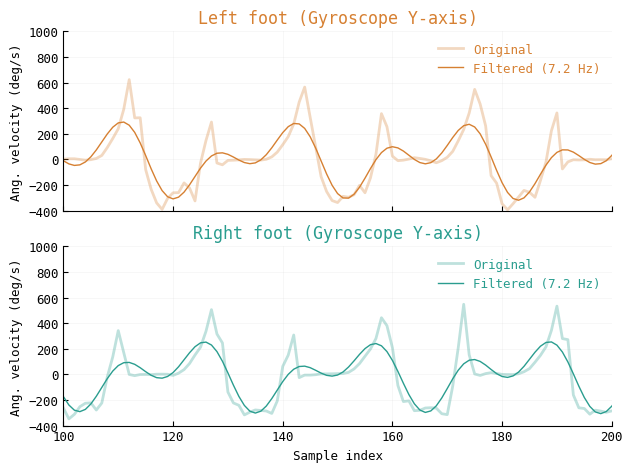

Filter applied: 4th order Butterworth low-pass at 7.2 Hz


In [5]:
from scipy.signal import butter, filtfilt, find_peaks

# Design Butterworth low-pass filter
def butter_lowpass_filter(data, cutoff, fs, order=4):
    """Apply a Butterworth low-pass filter to the data"""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Apply filter to both feet
left_foot_filtered = butter_lowpass_filter(left_foot, max_cutoff, fs, order=4)
right_foot_filtered = butter_lowpass_filter(right_foot, max_cutoff, fs, order=4)

# Plot original and filtered signals
fig, ax = plt.subplots(2, 1, sharex=True)

# Left foot
ax[0].plot(left_foot, label="Original", color=colours[0], alpha=0.3, linewidth=2)
ax[0].plot(left_foot_filtered, label=f"Filtered ({max_cutoff:.1f} Hz)", color=colours[0], linewidth=1)
ax[0].set_title("Left foot (Gyroscope Y-axis)")
ax[0].set_ylabel("Ang. velocity (deg/s)")
ax[0].legend(loc='upper right')
ax[0].set_xlim(100, 200)
ax[0].set_ylim(-400, 1000)

# Right foot
ax[1].plot(right_foot, label="Original", color=colours[1], alpha=0.3, linewidth=2)
ax[1].plot(right_foot_filtered, label=f"Filtered ({max_cutoff:.1f} Hz)", color=colours[1], linewidth=1)
ax[1].set_title("Right foot (Gyroscope Y-axis)", color=colours[1])
ax[1].set_xlabel("Sample index")
ax[1].set_ylabel("Ang. velocity (deg/s)")
ax[1].legend(loc='upper right')
ax[1].set_xlim(100, 200)
ax[1].set_ylim(-400, 1000)
plt.tight_layout()
plt.show()

print(f"Filter applied: 4th order Butterworth low-pass at {max_cutoff:.1f} Hz")

## 3. Peak detection

The filtered data now follows a clear trend: each local minima is followed by two local maxima.

From the typical healthy gait cycle, we see that these minima correspond to the time between the foot off and foot contact events.
![Gait cycle](../data/images/gait_cycle.png)


The local minima can therefore be used to locate the foot contact and foot off events. The conditions for a local minima are:
$$\omega(t) < \omega(t-1), ~ \omega(t)<\omega(t+1), ~ \omega(t)<std(\omega)$$

Detected 10 left foot peaks
Detected 9 right foot peaks


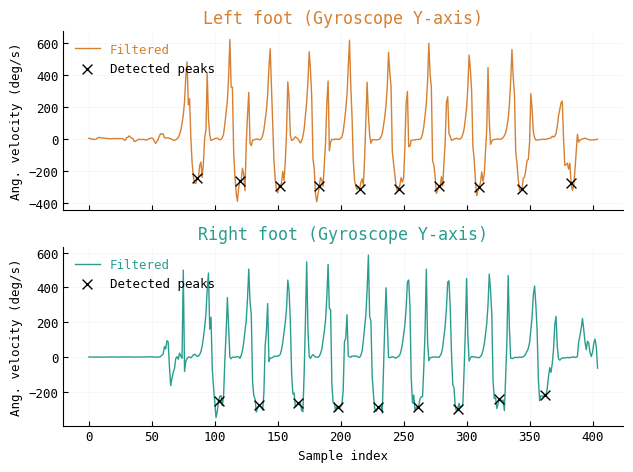

In [6]:
# Detect peaks (negative peaks for foot strikes)
peaks_left, _ = find_peaks(-left_foot_filtered, height=np.std(left_foot_filtered))
peaks_right, _ = find_peaks(-right_foot_filtered, height=np.std(right_foot_filtered))

print(f"Detected {len(peaks_left)} left foot peaks")
print(f"Detected {len(peaks_right)} right foot peaks")

# Plot filtered signal with detected peaks
fig, ax = plt.subplots(2, 1, sharex=True)

# Left foot
ax[0].plot(left_foot, label=f"Filtered", color=colours[0], linewidth=1)
ax[0].scatter(peaks_left, left_foot[peaks_left], color='black', s=50, zorder=5, label='Detected peaks', marker='x')
ax[0].set_title("Left foot (Gyroscope Y-axis)")
ax[0].set_ylabel("Ang. velocity (deg/s)")
ax[0].legend(loc='upper left')

# Right foot
ax[1].plot(right_foot, label=f"Filtered", color=colours[1], linewidth=1)
ax[1].scatter(peaks_right, right_foot[peaks_right], color='black', s=50, zorder=5, label='Detected peaks', marker='x')
ax[1].set_title("Right foot (Gyroscope Y-axis)", color=colours[1])
ax[1].set_xlabel("Sample index")
ax[1].set_ylabel("Ang. velocity (deg/s)")
ax[1].legend(loc='upper left')
plt.tight_layout()
plt.show()

### Foot Contact (Heel Strike) Detection

Using the detected mid-swing peaks, we can search forward to find the foot contact events. The foot contact occurs when the angular velocity changes sign (from negative to positive) after the mid-swing peak.

Detected 10 left foot contacts
Detected 9 right foot contacts


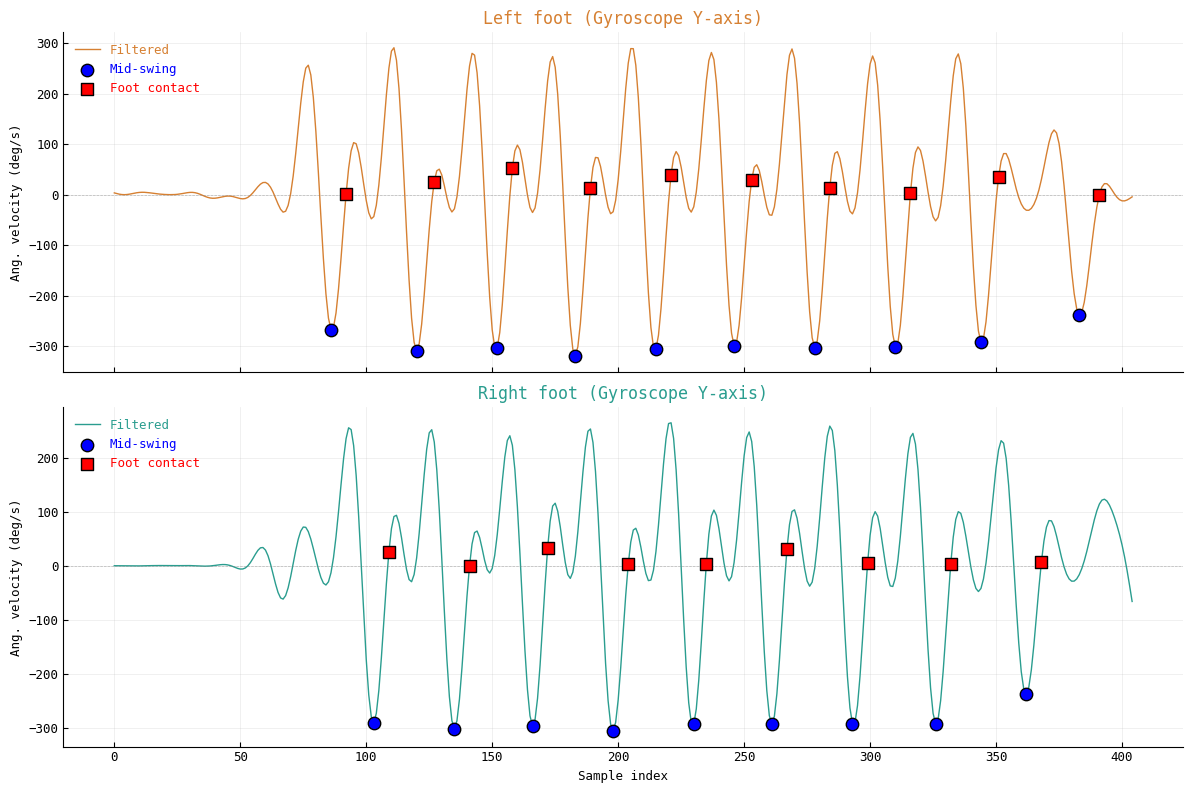

In [7]:
def detect_foot_contact(signal, mid_swing_peaks):
    """
    Detect foot contact events by searching forward from mid-swing peaks.
    Foot contact occurs when: signal[k] * signal[k-1] < 0 AND signal[k] > signal[k-1]
    """
    # Insert a fake mid-swing peak at the end to match array dimensions
    locs = np.insert(mid_swing_peaks, mid_swing_peaks.shape[0], signal.shape[0])
    
    FC = []
    
    for i in range(0, locs.shape[0]):
        # Search between consecutive mid-swing peaks
        for k in range(locs[i-1], locs[i]):
            # Check if angular velocity changes sign (negative to positive)
            if (signal[k] * signal[k-1] < 0) and (signal[k] > 0):
                FC.append(k)
                break
    
    return np.array(FC)

# Detect foot contact for both feet
FC_left = detect_foot_contact(left_foot_filtered, peaks_left)
FC_right = detect_foot_contact(right_foot_filtered, peaks_right)

print(f"Detected {len(FC_left)} left foot contacts")
print(f"Detected {len(FC_right)} right foot contacts")

# Plot filtered signal with mid-swing peaks and foot contacts
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# Left foot
ax[0].plot(left_foot_filtered, label=f"Filtered", color=colours[0], linewidth=1)
ax[0].scatter(peaks_left, left_foot_filtered[peaks_left], color='blue', s=80, zorder=5, 
             label='Mid-swing', marker='o', edgecolors='black', linewidths=1)
ax[0].scatter(FC_left, left_foot_filtered[FC_left], color='red', s=80, zorder=5, 
             label='Foot contact', marker='s', edgecolors='black', linewidths=1)
ax[0].axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax[0].set_title("Left foot (Gyroscope Y-axis)")
ax[0].set_ylabel("Ang. velocity (deg/s)")
ax[0].legend(loc='upper left')
ax[0].grid(True, alpha=0.3)

# Right foot
ax[1].plot(right_foot_filtered, label=f"Filtered", color=colours[1], linewidth=1)
ax[1].scatter(peaks_right, right_foot_filtered[peaks_right], color='blue', s=80, zorder=5, 
             label='Mid-swing', marker='o', edgecolors='black', linewidths=1)
ax[1].scatter(FC_right, right_foot_filtered[FC_right], color='red', s=80, zorder=5, 
             label='Foot contact', marker='s', edgecolors='black', linewidths=1)
ax[1].axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax[1].set_title("Right foot (Gyroscope Y-axis)", color=colours[1])
ax[1].set_xlabel("Sample index")
ax[1].set_ylabel("Ang. velocity (deg/s)")
ax[1].legend(loc='upper left')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Foot Off (Toe-Off) Detection

The foot off event occurs when the foot leaves the ground and begins the swing phase. We search **backwards** from each mid-swing peak to find the local maximum where the angular velocity is at its peak before transitioning to the swing phase.

Detected 9 left foot offs
Detected 9 right foot offs


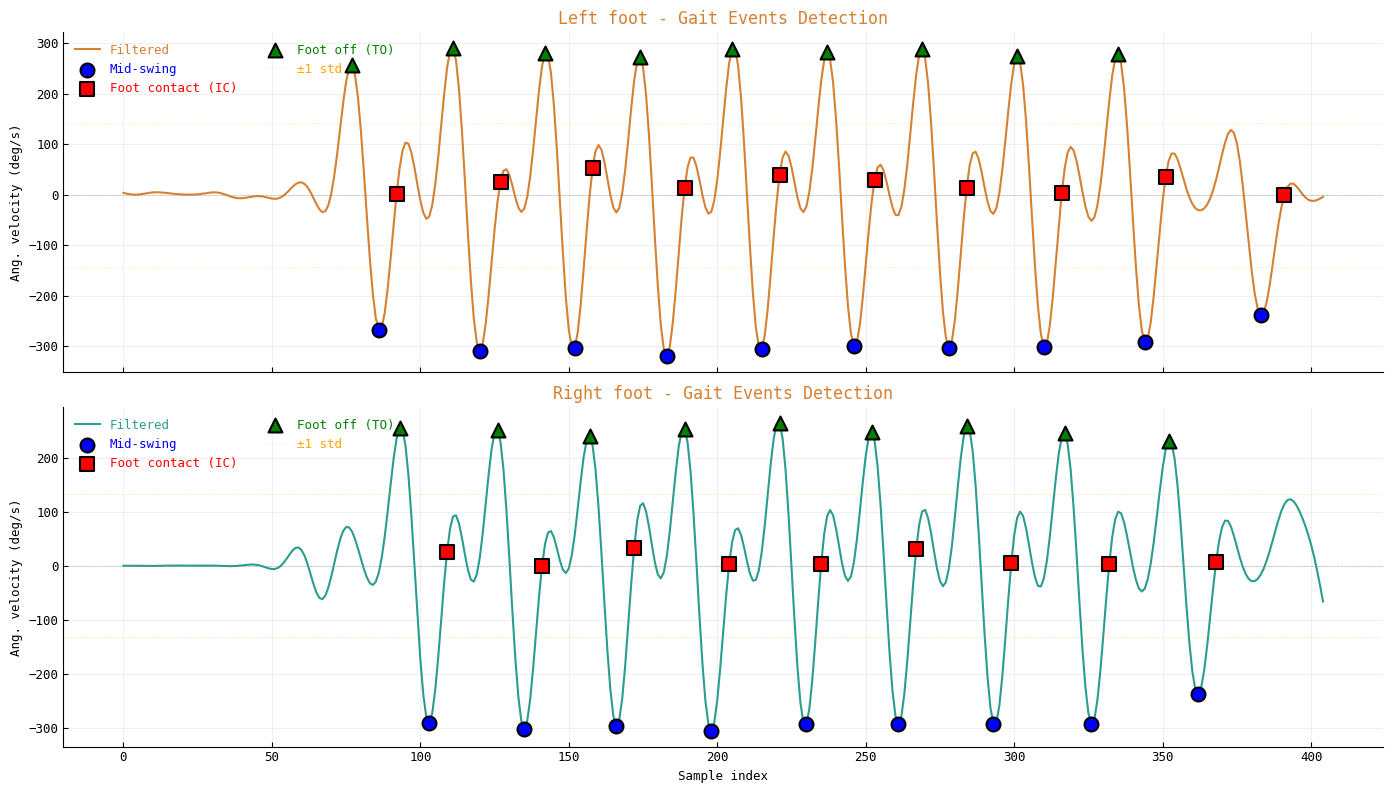


📊 Gait Events Summary:
Left foot:  10 contacts, 9 offs, 10 mid-swings
Right foot: 9 contacts, 9 offs, 9 mid-swings


In [ ]:
def detect_foot_off(signal, mid_swing_peaks):
    """
    Detect foot off events by searching backwards from mid-swing peaks.
    Foot off occurs at the local maximum before mid-swing where:
    signal[k] > signal[k-1] AND signal[k] > signal[k+1] AND signal[k] > std(signal)
    """
    FO = []
    
    # Insert fake peaks at start and end to comply with array dimensions
    locs = np.insert(mid_swing_peaks, 0, 0)
    locs = np.insert(locs, locs.shape[0], signal.shape[0] - 2)
    
    for i in range(0, locs.shape[0]):
        # Search backwards from current peak to previous peak
        for k in range(locs[i], locs[i-1], -1):
            # Check for local maximum above standard deviation threshold
            if (signal[k] > signal[k-1]) and (signal[k] > signal[k+1]) and (signal[k] > np.std(signal)):
                FO.append(k)
                break
    
    return np.array(FO)

# Detect foot off for both feet
FO_left = detect_foot_off(left_foot_filtered, peaks_left)
FO_right = detect_foot_off(right_foot_filtered, peaks_right)

print(f"Detected {len(FO_left)} left foot offs")
print(f"Detected {len(FO_right)} right foot offs")

# Plot filtered signal with all gait events
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(14, 8))

# Left foot
ax[0].plot(left_foot_filtered, label=f"Filtered", color=colours[0], linewidth=1.5)
ax[0].scatter(peaks_left, left_foot_filtered[peaks_left], color='blue', s=100, zorder=5, 
             label='Mid-swing', marker='o', edgecolors='black', linewidths=1.5)
ax[0].scatter(FC_left, left_foot_filtered[FC_left], color='red', s=100, zorder=5, 
             label='Foot contact (IC)', marker='s', edgecolors='black', linewidths=1.5)
ax[0].scatter(FO_left, left_foot_filtered[FO_left], color='green', s=100, zorder=5, 
             label='Foot off (TO)', marker='^', edgecolors='black', linewidths=1.5)
ax[0].axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax[0].axhline(y=np.std(left_foot_filtered), color='orange', linestyle=':', linewidth=0.5, alpha=0.5, label='±1 std')
ax[0].axhline(y=-np.std(left_foot_filtered), color='orange', linestyle=':', linewidth=0.5, alpha=0.5)
ax[0].set_title("Left foot - Gait Events Detection")
ax[0].set_ylabel("Ang. velocity (deg/s)")
ax[0].legend(loc='upper left', ncol=2)
ax[0].grid(True, alpha=0.3)

# Right foot
ax[1].plot(right_foot_filtered, label=f"Filtered", color=colours[1], linewidth=1.5)
ax[1].scatter(peaks_right, right_foot_filtered[peaks_right], color='blue', s=100, zorder=5, 
             label='Mid-swing', marker='o', edgecolors='black', linewidths=1.5)
ax[1].scatter(FC_right, right_foot_filtered[FC_right], color='red', s=100, zorder=5, 
             label='Foot contact (IC)', marker='s', edgecolors='black', linewidths=1.5)
ax[1].scatter(FO_right, right_foot_filtered[FO_right], color='green', s=100, zorder=5, 
             label='Foot off (TO)', marker='^', edgecolors='black', linewidths=1.5)
ax[1].axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax[1].axhline(y=np.std(right_foot_filtered), color='orange', linestyle=':', linewidth=0.5, alpha=0.5, label='±1 std')
ax[1].axhline(y=-np.std(right_foot_filtered), color='orange', linestyle=':', linewidth=0.5, alpha=0.5)
ax[1].set_title("Right foot - Gait Events Detection")
ax[1].set_xlabel("Sample index")
ax[1].set_ylabel("Ang. velocity (deg/s)")
ax[1].legend(loc='upper left', ncol=2)
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Gait Events Summary:")
print(f"Left foot:  {len(FC_left)} contacts, {len(FO_left)} offs, {len(peaks_left)} mid-swings")
print(f"Right foot: {len(FC_right)} contacts, {len(FO_right)} offs, {len(peaks_right)} mid-swings")